# **Import Libraries**

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import jaccard_score, precision_score, recall_score

# **Set Data paths**

In [3]:


# === 1. Set Paths ===
data_root = "/kaggle/input/brain-tumor-segmentation/Brain Tumour Br35H"  # Change this if needed (e.g., "/kaggle/input/Dataset")

image_dir = os.path.join(data_root, "images")
mask_dir = os.path.join(data_root, "masks")

train_img_dir = os.path.join(image_dir, "TRAIN")
val_img_dir = os.path.join(image_dir, "VAL")
test_img_dir = os.path.join(image_dir, "TEST")

# Verify paths
assert os.path.exists(train_img_dir), f"TRAIN folder not found: {train_img_dir}"
assert os.path.exists(val_img_dir), f"VAL folder not found: {val_img_dir}"
assert os.path.exists(test_img_dir), f"TEST folder not found: {test_img_dir}"
assert os.path.exists(mask_dir), f"Masks folder not found: {mask_dir}"

In [4]:
## Get Image Files (Ignore JSON)

def get_image_files(folder):
    """Get list of image files (ignore .json, .txt, etc.)"""
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    files = [
        f for f in os.listdir(folder)
        if f.lower().endswith(valid_exts) and not f.lower().endswith('.json')
    ]
    return sorted(files)

# Get all mask filenames for fast lookup
mask_files = get_image_files(mask_dir)
mask_set = set(mask_files)

print(f"Found {len(mask_files)} masks in 'masks/' folder")

Found 801 masks in 'masks/' folder


In [5]:
def create_pairs(image_folder, mask_dir, mask_set):
    """Create list of (image_path, mask_path) pairs"""
    image_files = get_image_files(image_folder)
    
    image_paths = []
    mask_paths = []
    
    for img_file in image_files:
        if img_file in mask_set:
            image_paths.append(os.path.join(image_folder, img_file))
            mask_paths.append(os.path.join(mask_dir, img_file))
        else:
            print(f"⚠️ Mask not found for image: {img_file}")
    
    return image_paths, mask_paths

# Create pairs for each split
train_image_paths, train_mask_paths = create_pairs(train_img_dir, mask_dir, mask_set)
val_image_paths, val_mask_paths = create_pairs(val_img_dir, mask_dir, mask_set)
test_image_paths, test_mask_paths = create_pairs(test_img_dir, mask_dir, mask_set)

# Summary
print("\n✅ Final Pair Counts:")
print(f"Training:   {len(train_image_paths)}")
print(f"Validation: {len(val_image_paths)}")
print(f"Testing:    {len(test_image_paths)}")


✅ Final Pair Counts:
Training:   500
Validation: 201
Testing:    100


# **Custom Dataset Class**

In [6]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask (grayscale)
        image = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        # Convert mask to binary: 0 (background), 1 (tumor)
        # mask = (np.array(mask) == 1).astype(np.uint8)
        # mask = Image.fromarray(mask)

        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Ensure mask is float tensor with values 0 or 1
        mask = (mask > 0.5).float()

        return image, mask

In [8]:
# Image transform: resize, tensor, normalize
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # [-1, 1] range
])

# Mask transform: resize (nearest neighbor), to tensor only — NO normalize!
mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()  # Values will be 0 or 1
])

# **DataLoader**

In [9]:
batch_size = 16

# Create datasets
train_dataset = BrainTumorDataset(
    train_image_paths, train_mask_paths,
    image_transform=image_transform,
    mask_transform=mask_transform
)

val_dataset = BrainTumorDataset(
    val_image_paths, val_mask_paths,
    image_transform=image_transform,
    mask_transform=mask_transform
)

test_dataset = BrainTumorDataset(
    test_image_paths, test_mask_paths,
    image_transform=image_transform,
    mask_transform=mask_transform
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# Final summary
print("\n✅ DataLoaders created!")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")


✅ DataLoaders created!
  Train batches: 32
  Val batches:   13
  Test batches:  100


In [10]:

for img,msk in train_loader:
    print()
    break
    

In [11]:
img.shape


torch.Size([16, 1, 256, 256])

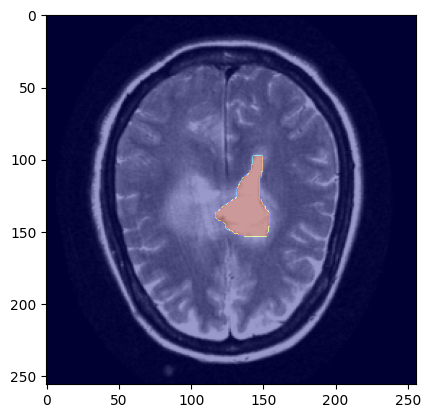

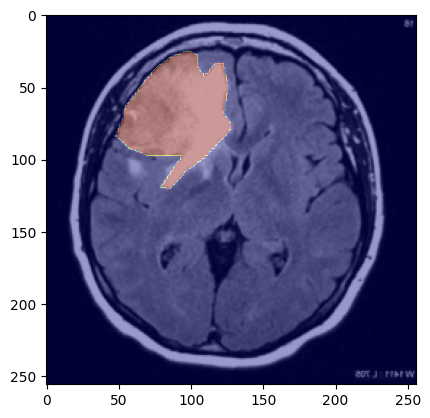

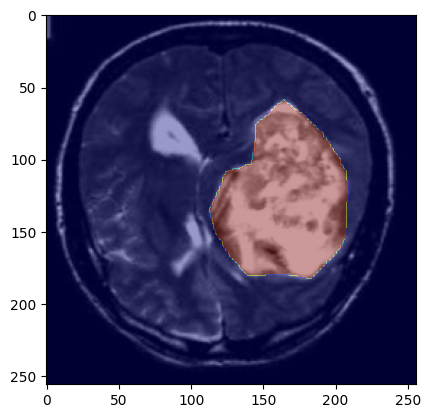

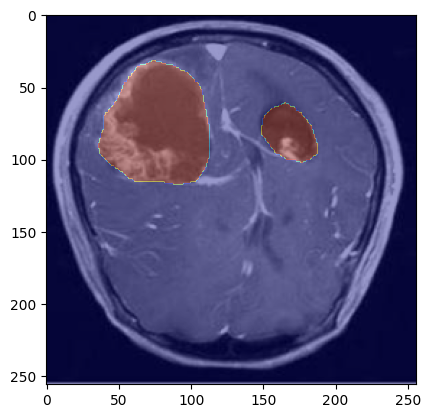

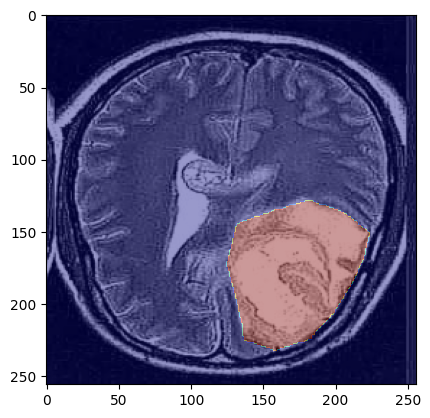

In [12]:


for i in range(5):
    plt.imshow(img[i,0],cmap='gray')
    plt.imshow(msk[i,0],cmap='jet',alpha=0.4)
    plt.show()

# **Unet Model**

In [ ]:


# class UNet(nn.Module):
#     def __init__(self, n_channels, n_classes, bilinear=False):
#         super(UNet, self).__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.bilinear = bilinear

#         self.inc = (DoubleConv(n_channels, 64))
#         self.down1 = (Down(64, 128))
#         self.down2 = (Down(128, 256))
#         self.down3 = (Down(256, 512))
#         factor = 2 if bilinear else 1
#         self.down4 = (Down(512, 1024 // factor))
#         self.up1 = (Up(1024, 512 // factor, bilinear))
#         self.up2 = (Up(512, 256 // factor, bilinear))
#         self.up3 = (Up(256, 128 // factor, bilinear))
#         self.up4 = (Up(128, 64, bilinear))
#         self.outc = (OutConv(64, n_classes))

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x5 = self.down4(x4)
#         x = self.up1(x5, x4)
#         x = self.up2(x, x3)
#         x = self.up3(x, x2)
#         x = self.up4(x, x1)
#         logits = self.outc(x)
#         return logits


# class DoubleConv(nn.Module):
#     """(conv => BN => ReLU) * 2"""
#     def __init__(self, in_channels, out_channels):
#         super(DoubleConv, self).__init__()
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)

# class Down(nn.Module):
#     """MaxPool + DoubleConv"""
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.maxpool_conv = nn.Sequential(
#             nn.MaxPool2d(2),
#             DoubleConv(in_channels, out_channels)
#         )

#     def forward(self, x):
#         return self.maxpool_conv(x)

# class Up(nn.Module):
#     """Upsample + Conv (or Transposed Conv) + DoubleConv"""
#     def __init__(self, in_channels, out_channels, bilinear=True):
#         super(Up, self).__init__()

#         if bilinear:
#             self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#             self.conv = DoubleConv(in_channels, out_channels)
#         else:
#             self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
#             self.conv = DoubleConv(in_channels, out_channels)

#     def forward(self, x1, x2):
#         x1 = self.up(x1)
#         # Crop and concatenate skip connection
#         diffY = x2.size()[2] - x1.size()[2]
#         diffX = x2.size()[3] - x1.size()[3]
#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                         diffY // 2, diffY - diffY // 2])
#         x = torch.cat([x2, x1], dim=1)
#         return self.conv(x)

# class OutConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(OutConv, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

#     def forward(self, x):
#         return self.conv(x)
    

# **Attention Unet**

In [13]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        # number of input channels is a number of filters in the previous layer
        # number of output channels is a number of filters in the current layer
        # "same" convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch, output_ch):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) # concatenate attention-weighted skip connection with previous layer output
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out

In [14]:
# For binary segmentation (tumor vs background)
n_classes = 1
n_channels = 1  # Grayscale MRI

# model = UNet(n_channels=n_channels, n_classes=n_classes, bilinear=False)  # bilinear=False → use transpose conv

model = AttentionUNet(img_ch=1, output_ch=1)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model loaded on {device}")

Model loaded on cuda


In [15]:
# Binary Cross-Entropy + Sigmoid
# bce_loss = nn.BCEWithLogitsLoss()  # Use this if you're NOT applying sigmoid in model

# Or if you add sigmoid:
# bce_loss = nn.BCELoss()

# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)  # Apply sigmoid
        inter = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * inter + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

criterion = DiceLoss()  # or use bce_loss or combined
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Define scheduler
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',        # Monitor validation loss
    patience=5,        # Wait 5 epochs
    factor=0.5,        # Reduce LR by half
    verbose=True       # Print updates
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# **Training Loop**

In [16]:
# Number of epochs
num_epochs = 50

# Lists to store logs for plotting
train_losses = []
val_losses = []
val_dice_scores = []
val_iou_scores = []
val_precision_scores = []
val_recall_scores = []

for epoch in range(num_epochs):
    # === Training ===
    model.train()
    running_train_loss = 0.0

    # Progress bar for training
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    
    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        train_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # === Validation ===
    model.eval()
    running_val_loss = 0.0
    dice_scores = []
    iou_scores = []
    precision_scores = []
    recall_scores = []

    # Progress bar for validation
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val  ]", leave=False)

    with torch.no_grad():
        for images, masks in val_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            val_loss = criterion(outputs, masks)
            running_val_loss += val_loss.item()

            # Sigmoid + threshold
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            # Flatten
            flat_true = (masks.cpu().numpy().flatten() > 0.5).astype(int)
            flat_pred = (preds.cpu().numpy().flatten() > 0.5).astype(int)

            if flat_true.sum() == 0 and flat_pred.sum() == 0:
                dice_scores.append(1.0)
                iou_scores.append(1.0)
                precision_scores.append(1.0)
                recall_scores.append(1.0)
            else:
                dice = 2 * (flat_pred * flat_true).sum() / (flat_pred.sum() + flat_true.sum() + 1e-8)
                dice_scores.append(dice)
                iou_scores.append(jaccard_score(flat_true, flat_pred, average='binary', zero_division=0))
                precision_scores.append(precision_score(flat_true, flat_pred, average='binary', zero_division=0))
                recall_scores.append(recall_score(flat_true, flat_pred, average='binary', zero_division=0))

            val_bar.set_postfix({"Loss": f"{val_loss.item():.4f}"})

    # Average validation metrics
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_dice_scores.append(np.mean(dice_scores))
    val_iou_scores.append(np.mean(iou_scores))
    val_precision_scores.append(np.mean(precision_scores))
    val_recall_scores.append(np.mean(recall_scores))

    # Step scheduler
    scheduler.step(avg_val_loss)

    # Final log for epoch
    print(f"Epoch [{epoch+1:2d}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} "
          f"Val Loss: {avg_val_loss:.4f} "
          f"Dice: {val_dice_scores[-1]:.4f} "
          f"IoU: {val_iou_scores[-1]:.4f}")

Epoch [ 1/50] Train Loss: 0.8073 Val Loss: 0.8176 Dice: 0.2907 IoU: 0.1721


Epoch [ 2/50] Train Loss: 0.7663 Val Loss: 0.7739 Dice: 0.3854 IoU: 0.2409


Epoch [ 3/50] Train Loss: 0.7445 Val Loss: 0.7381 Dice: 0.5378 IoU: 0.3756


Epoch [ 4/50] Train Loss: 0.7322 Val Loss: 0.7232 Dice: 0.5952 IoU: 0.4258


Epoch [ 5/50] Train Loss: 0.7101 Val Loss: 0.6562 Dice: 0.6993 IoU: 0.5465


Epoch [ 6/50] Train Loss: 0.6948 Val Loss: 0.6551 Dice: 0.6804 IoU: 0.5214


Epoch [ 7/50] Train Loss: 0.6828 Val Loss: 0.6868 Dice: 0.5877 IoU: 0.4188


Epoch [ 8/50] Train Loss: 0.6591 Val Loss: 0.6778 Dice: 0.7320 IoU: 0.5854


Epoch [ 9/50] Train Loss: 0.6368 Val Loss: 0.7399 Dice: 0.5338 IoU: 0.3732


Epoch [10/50] Train Loss: 0.6326 Val Loss: 0.6233 Dice: 0.6948 IoU: 0.5476


Epoch [11/50] Train Loss: 0.6124 Val Loss: 0.5795 Dice: 0.8087 IoU: 0.6830


Epoch [12/50] Train Loss: 0.5878 Val Loss: 0.5965 Dice: 0.7039 IoU: 0.5466


Epoch [13/50] Train Loss: 0.5781 Val Loss: 0.5255 Dice: 0.7556 IoU: 0.6227


Epoch [14/50] Train Loss: 0.5656 Val Loss: 0.5417 Dice: 0.7413 IoU: 0.6001


Epoch [15/50] Train Loss: 0.5547 Val Loss: 0.5632 Dice: 0.7533 IoU: 0.6161


Epoch [16/50] Train Loss: 0.5400 Val Loss: 0.5703 Dice: 0.6169 IoU: 0.4757


Epoch [17/50] Train Loss: 0.5243 Val Loss: 0.4881 Dice: 0.8469 IoU: 0.7385


Epoch [18/50] Train Loss: 0.5221 Val Loss: 0.4479 Dice: 0.8331 IoU: 0.7192


Epoch [19/50] Train Loss: 0.5086 Val Loss: 0.5220 Dice: 0.7735 IoU: 0.6389


Epoch [20/50] Train Loss: 0.4914 Val Loss: 0.4702 Dice: 0.8390 IoU: 0.7277


Epoch [21/50] Train Loss: 0.4688 Val Loss: 0.3926 Dice: 0.8605 IoU: 0.7582


Epoch [22/50] Train Loss: 0.4506 Val Loss: 0.4721 Dice: 0.8659 IoU: 0.7657


Epoch [23/50] Train Loss: 0.4401 Val Loss: 0.4696 Dice: 0.8274 IoU: 0.7117


Epoch [24/50] Train Loss: 0.4242 Val Loss: 0.4153 Dice: 0.7918 IoU: 0.6738


Epoch [25/50] Train Loss: 0.4147 Val Loss: 0.4188 Dice: 0.8295 IoU: 0.7147


Epoch [26/50] Train Loss: 0.4159 Val Loss: 0.4554 Dice: 0.7914 IoU: 0.6596


Epoch [27/50] Train Loss: 0.4185 Val Loss: 0.4061 Dice: 0.8217 IoU: 0.7034


Epoch [28/50] Train Loss: 0.3838 Val Loss: 0.3770 Dice: 0.8678 IoU: 0.7699


Epoch [29/50] Train Loss: 0.3701 Val Loss: 0.3675 Dice: 0.8814 IoU: 0.7901


Epoch [30/50] Train Loss: 0.3591 Val Loss: 0.3442 Dice: 0.8875 IoU: 0.7989


Epoch [31/50] Train Loss: 0.3519 Val Loss: 0.3898 Dice: 0.8809 IoU: 0.7884


Epoch [32/50] Train Loss: 0.3501 Val Loss: 0.3264 Dice: 0.8826 IoU: 0.7914


Epoch [33/50] Train Loss: 0.3484 Val Loss: 0.3259 Dice: 0.8876 IoU: 0.7985


Epoch [34/50] Train Loss: 0.3430 Val Loss: 0.3607 Dice: 0.8518 IoU: 0.7433


Epoch [35/50] Train Loss: 0.3329 Val Loss: 0.3333 Dice: 0.8884 IoU: 0.7996


Epoch [36/50] Train Loss: 0.3224 Val Loss: 0.3325 Dice: 0.8764 IoU: 0.7820


Epoch [37/50] Train Loss: 0.3099 Val Loss: 0.3351 Dice: 0.9009 IoU: 0.8200


Epoch [38/50] Train Loss: 0.3046 Val Loss: 0.3167 Dice: 0.9004 IoU: 0.8190


Epoch [39/50] Train Loss: 0.2912 Val Loss: 0.2973 Dice: 0.8998 IoU: 0.8182


Epoch [40/50] Train Loss: 0.2878 Val Loss: 0.3280 Dice: 0.9028 IoU: 0.8231


Epoch [41/50] Train Loss: 0.2819 Val Loss: 0.3207 Dice: 0.9007 IoU: 0.8196


Epoch [42/50] Train Loss: 0.2723 Val Loss: 0.2988 Dice: 0.8920 IoU: 0.8054


Epoch [43/50] Train Loss: 0.2640 Val Loss: 0.2857 Dice: 0.9022 IoU: 0.8219


Epoch [44/50] Train Loss: 0.2612 Val Loss: 0.2894 Dice: 0.8992 IoU: 0.8171


Epoch [45/50] Train Loss: 0.2512 Val Loss: 0.2734 Dice: 0.9028 IoU: 0.8229


Epoch [46/50] Train Loss: 0.2477 Val Loss: 0.2759 Dice: 0.8872 IoU: 0.7979


Epoch [47/50] Train Loss: 0.2450 Val Loss: 0.2873 Dice: 0.8746 IoU: 0.7785


Epoch [48/50] Train Loss: 0.2365 Val Loss: 0.2822 Dice: 0.8962 IoU: 0.8123


Epoch [49/50] Train Loss: 0.2292 Val Loss: 0.2607 Dice: 0.8970 IoU: 0.8135


Epoch [50/50] Train Loss: 0.2350 Val Loss: 0.2521 Dice: 0.9005 IoU: 0.8192


In [ ]:
# torch.save(model.state_dict(), "unet_brain_tumor.pth")
torch.save(model.state_dict(), "attention_unet_brain_tumor.pth")



In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- Plot Dice & IoU ---
plt.figure(figsize=(8,6))
plt.plot(val_dice_scores, label="Val Dice")
plt.plot(val_iou_scores, label="Val IoU")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Validation Dice & IoU")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- Plot Precision & Recall ---
plt.figure(figsize=(8,6))
plt.plot(val_precision_scores, label="Val Precision")
plt.plot(val_recall_scores, label="Val Recall")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Validation Precision & Recall")
plt.legend()
plt.grid(True)
plt.show()

# **Testing**

In [ ]:
# === Testing Loop ===
model.eval()
test_dice_scores = []
test_iou_scores = []
test_precision_scores = []
test_recall_scores = []
test_losses = []

test_bar = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for images, masks in test_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        test_loss = criterion(outputs, masks)
        test_losses.append(test_loss.item())

        # Sigmoid + threshold
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        # Flatten
        flat_true = (masks.cpu().numpy().flatten() > 0.5).astype(int)
        flat_pred = (preds.cpu().numpy().flatten() > 0.5).astype(int)

        if flat_true.sum() == 0 and flat_pred.sum() == 0:
            dice = 1.0
            iou = 1.0
            precision = 1.0
            recall = 1.0
        else:
            dice = 2 * (flat_pred * flat_true).sum() / (flat_pred.sum() + flat_true.sum() + 1e-8)
            iou = jaccard_score(flat_true, flat_pred, average='binary', zero_division=0)
            precision = precision_score(flat_true, flat_pred, average='binary', zero_division=0)
            recall = recall_score(flat_true, flat_pred, average='binary', zero_division=0)

        test_dice_scores.append(dice)
        test_iou_scores.append(iou)
        test_precision_scores.append(precision)
        test_recall_scores.append(recall)

        test_bar.set_postfix({"Loss": f"{test_loss.item():.4f}"})

# Average test metrics
avg_test_loss = np.mean(test_losses)
avg_test_dice = np.mean(test_dice_scores)
avg_test_iou = np.mean(test_iou_scores)
avg_test_precision = np.mean(test_precision_scores)
avg_test_recall = np.mean(test_recall_scores)

print("\n=== Test Results ===")
print(f"Test Loss     : {avg_test_loss:.4f}")
print(f"Dice Score    : {avg_test_dice:.4f}")
print(f"IoU           : {avg_test_iou:.4f}")
print(f"Precision     : {avg_test_precision:.4f}")
print(f"Recall        : {avg_test_recall:.4f}")


In [ ]:
# Plot Dice score per batch in test set
plt.figure(figsize=(8,5))
plt.plot(range(1, len(test_dice_scores)+1), test_dice_scores, marker='o', color='blue')
plt.title("Dice Score on Test Set (per batch)")
plt.xlabel("Batch")
plt.ylabel("Dice Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader))  # Take one batch
    images, masks = images.to(device), masks.to(device)
    outputs = model(images)
    preds = (torch.sigmoid(outputs) > 0.5).float()

# Plot first sample in batch
idx = 0
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(images[idx].permute(1,2,0).cpu())  # image
plt.title("Input Image")

plt.subplot(1,3,2)
plt.imshow(masks[idx,0].cpu(), cmap='gray')  # ground truth
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(preds[idx,0].cpu(), cmap='gray')  # prediction
plt.title("Prediction")
plt.show()
